<a href="https://colab.research.google.com/github/Pearlkakande/machinelearning/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install necessary packages (uncomment if needed)
!pip install datasets torch wandb sentence-transformers scikit-learn
!pip install torch-scatter torch-sparse torch-cluster torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.nn import GCNConv, GATConv  # and other layers as needed
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import wandb
import numpy as np
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1E

In [4]:
# (Global W&B login is fine to do once)
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pearlkakande (pearlkakande-makerere-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# Load the dataset from Hugging Face
dataset = load_dataset("Eitanli/goodreads")["train"]  # assume 'train' split
df = pd.DataFrame(dataset)
print(df.columns.tolist())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/737 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


goodreads_data.csv:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

['Unnamed: 0', 'Book', 'Author', 'Description', 'Genres', 'Avg_Rating', 'Num_Ratings', 'URL']


In [5]:
# Use a pre-trained sentence transformer to embed the book descriptions.
model_st = SentenceTransformer('all-MiniLM-L6-v2')
df['desc_emb'] = df['Description'].fillna("").apply(lambda x: model_st.encode(x))


# Split into train/test (e.g., 80/20 split by index for simplicity)
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# Build a simple heterogeneous graph (using PyG's HeteroData):
def build_hetero_graph(df):
    data = HeteroData()

    # Create book nodes: use description embeddings as features.
    book_emb = np.stack(df['desc_emb'].values)
    data['book'].x = torch.tensor(book_emb, dtype=torch.float)

    # For authors and genres, create a mapping.
    authors = list(df['Author'].unique())
    genres = list(df['Genres'].unique())
    author2id = {a: i for i, a in enumerate(authors)}
    genre2id = {g: i for i, g in enumerate(genres)}

    # Create author nodes with one-hot features.
    data['author'].num_nodes = len(authors)
    data['author'].x = F.one_hot(torch.arange(len(authors)), num_classes=len(authors)).float()

    # Create genre nodes.
    data['genre'].num_nodes = len(genres)
    data['genre'].x = F.one_hot(torch.arange(len(genres)), num_classes=len(genres)).float()

    # Build edges: book -> author and book -> genre.
    book_ids = np.arange(len(df))
    author_ids = [author2id[a] for a in df['Author']]
    genre_ids = [genre2id[g] for g in df['Genres']]

    data['book', 'written_by', 'author'].edge_index = torch.tensor([book_ids, author_ids], dtype=torch.long)
    data['book', 'has_genre', 'genre'].edge_index = torch.tensor([book_ids, genre_ids], dtype=torch.long)

    # (Optional) Build book-to-book similarity edges based on cosine similarity between description embeddings:
    # For simplicity, here we add edges for pairs with similarity > 0.9.
    from sklearn.metrics.pairwise import cosine_similarity
    sim_matrix = cosine_similarity(book_emb)
    src, dst = np.where(sim_matrix > 0.9)
    # remove self-loops:
    mask = src != dst
    data['book', 'similar_to', 'book'].edge_index = torch.tensor([src[mask], dst[mask]], dtype=torch.long)

    # You can also include rating-based popularity as a node attribute or as edge weight.
    # For example, store ratings_count and average_rating in a separate tensor.
    #convert num ratings to int type for later manipulation
    df['Num_Ratings'] = df['Num_Ratings'].str.replace(',', '').astype(int)
    data['book'].ratings_count = torch.tensor(df['Num_Ratings'].values.astype(float), dtype=torch.float)
    data['book'].average_rating = torch.tensor(df['Avg_Rating'].values.astype(float), dtype=torch.float)

    return data

data = build_hetero_graph(train_df)  # build graph from training data

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-5-209a83e14140>:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  data['book', 'written_by', 'author'].edge_index = torch.tensor([book_ids, author_ids], dtype=torch.long)


MultiViewGNN Epoch 0: Loss=3581.7019
MultiViewGNN Epoch 10: Loss=59.5941
MultiViewGNN Epoch 20: Loss=97.0983
          Model        Loss  Accuracy  Precision  Recall        F1
0  MultiViewGNN  106.057404   0.52375   0.512164     1.0  0.677392
Confusion Matrix:
[[ 190 3810]
 [   0 4000]]


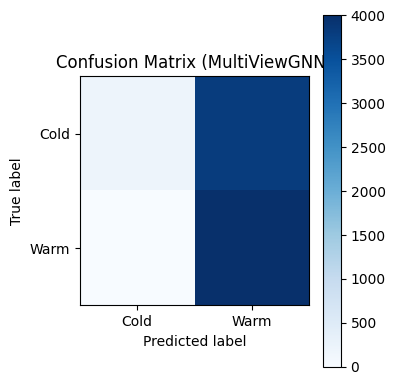

accuracy,▆▆▅▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f1,▁▁▁▁██████████████████████████
loss,█▆▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁██████████████████████████
recall,▁▁▁▁██████████████████████████
Model,MultiViewGNN
accuracy,0.52375
epoch,29
f1,0.67739
loss,106.0574


In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Initialize wandb before training the model
wandb.init(project="book-model",    # Replace with your project name
           entity="pearlkakande-makerere-university",  # Replace with your wandb username or team name
           config={"model": "MultiViewGNN", "epochs": 30, "learning_rate": 0.005})

# Define warm items based on ratings_count > threshold.
threshold = train_df['Num_Ratings'].median()
labels = (train_df['Num_Ratings'] > threshold).astype(int).values
labels = torch.tensor(labels, dtype=torch.long)

class MultiViewGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(MultiViewGNN, self).__init__()
        # Collaborative view branch (using popularity)
        self.collab_conv = GCNConv(in_channels, hidden_channels)
        # Content view branch
        self.content_conv = GCNConv(in_channels, hidden_channels)
        # Fusion: concatenate both views and popularity, then classify
        self.fusion_lin = nn.Linear(hidden_channels * 2 + 1, 2)

    def forward(self, data):
        # Collaborative view: use the same edge_index for demo purposes
        x_collab = F.relu(self.collab_conv(data['book'].x, data['book', 'similar_to', 'book'].edge_index))
        # Content view: here, for simplicity, we use the same input features
        x_content = F.relu(self.content_conv(data['book'].x, data['book', 'similar_to', 'book'].edge_index))
        # Fusion: concatenate both views and the popularity signal
        ratings = data['book'].ratings_count.unsqueeze(1)
        x_fused = torch.cat([x_collab, x_content, ratings], dim=1)
        out = self.fusion_lin(x_fused)
        return out, x_collab, x_content

# Set device and create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model10 = MultiViewGNN(in_channels=data['book'].x.size(1), hidden_channels=32).to(device)
optimizer10 = torch.optim.Adam(model10.parameters(), lr=0.005)

# Move data and labels to device
data['book'].x = data['book'].x.to(device)
data['book', 'similar_to', 'book'].edge_index = data['book', 'similar_to', 'book'].edge_index.to(device)
data['book'].ratings_count = data['book'].ratings_count.to(device)
labels = labels.to(device)

# Training loop for 30 epochs
num_epochs = 30
model10.train()
for epoch in range(num_epochs):
    optimizer10.zero_grad()
    out, view1, view2 = model10(data)
    # Classification loss
    loss_class = F.cross_entropy(out, labels)
    # Alignment loss: force the two views to be close (MSE)
    loss_align = F.mse_loss(view1, view2)
    loss_total = loss_class + 0.5 * loss_align
    loss_total.backward()
    optimizer10.step()

    preds = out.argmax(dim=1).cpu().numpy()
    true_labels = labels.cpu().numpy()
    acc = accuracy_score(true_labels, preds)
    prec = precision_score(true_labels, preds, zero_division=0)
    rec = recall_score(true_labels, preds, zero_division=0)
    f1 = f1_score(true_labels, preds, zero_division=0)

    wandb.log({"Model": "MultiViewGNN", "epoch": epoch, "loss": loss_total.item(),
               "accuracy": acc, "precision": prec, "recall": rec, "f1": f1})

    if epoch % 10 == 0:
        print(f"MultiViewGNN Epoch {epoch}: Loss={loss_total.item():.4f}")

results10 = {"Model": "MultiViewGNN", "Loss": loss_total.item(), "Accuracy": acc,
             "Precision": prec, "Recall": rec, "F1": f1}
print(pd.DataFrame([results10]))

# Compute confusion matrix on training data
cm = confusion_matrix(true_labels, preds)
print("Confusion Matrix:")
print(cm)

# Plot and log the confusion matrix as a plot to wandb
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (MultiViewGNN)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Cold", "Warm"])
plt.yticks(tick_marks, ["Cold", "Warm"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

# Finish the wandb run
wandb.finish()



XAI

In [13]:
!pip install LIME captum
import torch
import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import captum.attr as captum

def prepare_feature_names(data):
    """
    Automatically generate feature names if not provided

    Args:
    - data: Input data tensor

    Returns:
    - List of feature names
    """
    # Get number of features from input tensor
    n_features = data['book'].x.size(1)

    # Generate generic feature names
    feature_names = [f'feature_{i}' for i in range(n_features)]

    return feature_names

def lime_explanation(model, data, labels, feature_names=None):
    """
    LIME (Local Interpretable Model-agnostic Explanations) for MultiViewGNN

    Args:
    - model: Trained MultiViewGNN model
    - data: Input data tensor
    - labels: True labels
    - feature_names: Optional list of feature names

    Returns:
    - LIME explanations for a few sample predictions
    """
    # Prepare model for evaluation
    model.eval()

    # If feature names not provided, generate them
    if feature_names is None:
        feature_names = prepare_feature_names(data)

    # Convert data to numpy for LIME
    X = data['book'].x.cpu().numpy()
    y = labels.cpu().numpy()

    # Create LIME explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X,
        feature_names=feature_names,
        class_names=['Cold', 'Warm'],
        verbose=True,
        mode='classification'
    )

    # Function to predict probabilities
    def predict_proba(X):
        X_tensor = torch.tensor(X, dtype=torch.float).to(device)
        with torch.no_grad():
            out, _, _ = model({'book': {'x': X_tensor}})
            return out.softmax(dim=1).cpu().numpy()

    # Explain a few predictions
    plt.figure(figsize=(15, 5))
    n_samples = min(3, len(X))

    for i in range(n_samples):
        # Explain the instance
        exp = explainer.explain_instance(
            X[i],
            predict_proba,
            num_features=5,  # Top 5 important features
            labels=(0, 1)   # Explain both classes
        )

        # Plot LIME explanation
        plt.subplot(1, n_samples, i+1)
        exp.as_pyplot_figure()
        plt.title(f'LIME Explanation for Sample {i}')

    plt.tight_layout()
    plt.show()

def integrated_gradients_explanation(model, data, labels, feature_names=None):
    """
    Integrated Gradients for MultiViewGNN

    Args:
    - model: Trained MultiViewGNN model
    - data: Input data tensor
    - labels: True labels
    - feature_names: Optional list of feature names

    Returns:
    - Integrated Gradients attributions
    """
    # Prepare model for evaluation
    model.eval()

    # If feature names not provided, generate them
    if feature_names is None:
        feature_names = prepare_feature_names(data)

    # Create baseline (all zeros)
    baseline = torch.zeros_like(data['book'].x)

    # Integrated Gradients for the first view (collaborative view)
    ig = captum.IntegratedGradients(
        lambda x: model({'book': {'x': x}})[0]
    )

    # Compute attributions
    attributions, _ = ig.attribute(
        data['book'].x,
        baseline,
        target=labels,
        return_convergence_delta=True
    )

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot feature importances
    attr_sum = torch.abs(attributions).mean(dim=0).cpu().numpy()
    top_indices = attr_sum.argsort()[-5:][::-1]  # Top 5 features

    plt.bar(
        [feature_names[i] for i in top_indices],
        attr_sum[top_indices]
    )
    plt.title('Integrated Gradients: Top 5 Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Attribution Magnitude')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return attributions

# Example usage (modified to handle potential feature name issues)
try:
    # Try to use existing feature names if available
    feature_names = list(train_df.columns)
except:
    # If train_df is not available, use None to trigger automatic generation
    feature_names = None

# Perform explanations
print("LIME Explanation:")
lime_explanation(model10, data, labels, feature_names)

print("\nIntegrated Gradients Explanation:")
integrated_gradients_explanation(model10, data, labels, feature_names)

LIME Explanation:


IndexError: list index out of range